In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv('confessions_tweets.csv', usecols = ['Text', 'Favorites', 'Retweets', 'Sentiment'])

In [ ]:
df.head()

,Text,Sentiment,Favorites,Retweets
0,ras are you in debt,-1.0,2,0
1,guys at this rate of releasing season mixes I'...,0.0,2,0
2,how do I practice this philthy set if they hav...,0.0,0,0
3,O G KUSH WHERE ARE YOUR MIXES,0.0,0,0
4,Is there a reason I can’t drunk watch Rangeelo...,0.0,0,0


In [ ]:
df = df.head(500)

In [ ]:
print(df.iloc[-1])

Text         damn what is in that orlando water
Sentiment                                  -2.0
Favorites                                     2
Retweets                                      0
Name: 499, dtype: object


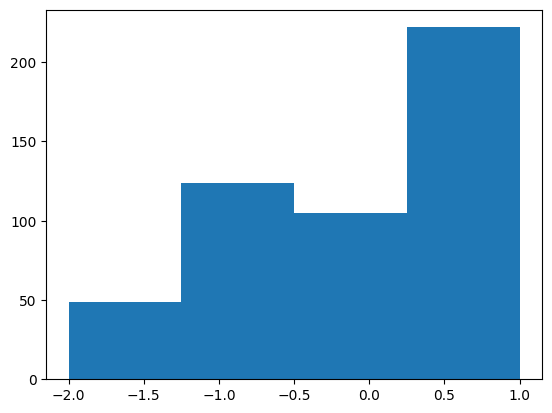

In [ ]:
plt.hist(df.Sentiment, bins=4)
plt.show()

In [ ]:
df['Score'] = (df['Sentiment'] + 2) / 3

In [ ]:
df.head()

,Text,Sentiment,Favorites,Retweets,Score
0,ras are you in debt,-1.0,2,0,0.333333
1,guys at this rate of releasing season mixes I'...,0.0,2,0,0.666667
2,how do I practice this philthy set if they hav...,0.0,0,0,0.666667
3,O G KUSH WHERE ARE YOUR MIXES,0.0,0,0,0.666667
4,Is there a reason I can’t drunk watch Rangeelo...,0.0,0,0,0.666667


In [ ]:
df['Approval'] = (df['Score'] >= 0.5).astype(int)

In [ ]:
# df.drop(['Label'], axis=1)

,Text,Sentiment,Favorites,Retweets,Score,Approval
0,ras are you in debt,-1.0,2,0,0.333333,0
1,guys at this rate of releasing season mixes I'...,0.0,2,0,0.666667,1
2,how do I practice this philthy set if they hav...,0.0,0,0,0.666667,1
3,O G KUSH WHERE ARE YOUR MIXES,0.0,0,0,0.666667,1
4,Is there a reason I can’t drunk watch Rangeelo...,0.0,0,0,0.666667,1
...,...,...,...,...,...,...
495,Okay we'll say it: RAS should take all 5 point...,0.0,5,0,0.666667,1
496,nakhraas guys and girls solos are such a stron...,1.0,2,0,1.000000,1
497,so obvious when a director is tweeting about t...,-1.0,0,0,0.333333,0
498,holy crap RAS is just over a month away,0.0,0,0,0.666667,1


In [ ]:
simple_df = df[['Text', 'Approval']]

In [ ]:
train, validate, test = np.split(simple_df.sample(frac=1), [int(0.6*len(simple_df)), int(0.8*len(simple_df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=16):
  df = dataframe.copy()
  labels = df.pop('Approval')
  df = df["Text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
validate_data = df_to_dataset(validate)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

(<tf.Tensor: shape=(16,), dtype=string, numpy=
 array([b'taaza board with their twitter fingers...',
        b'IU hoosierraas please please please smell my butt bc it loves u guys',
        b'ucf deserved ras', b'I miss the og cmu team \xf0\x9f\x98\xa2',
        b'comps with 3 directors>>',
        b'The girl that does all those spins in philthy raas girls solo slays',
        b'CMU 2020 IS YOUR CHAMPION!!!!!',
        b'RCR liaison is in my DM\xe2\x80\x99s. He wants me soo bad he said he will eat me',
        b'Disappointed about how expensive RAS is\xe2\x80\xa6',
        b'tall dark guy at the front of philthy boys solo ATE',
        b'i wish the ucf video had how loud the crowd was you could feel the love in the venue i\xe2\x80\x99m still shaking',
        b'masti mixer went HARDDDDD. as a senior, that was the best mixer I\xe2\x80\x99ve ever gone to period',
        b'That UCF x GT TikTok mad funny but rlly shows how UCF are such good sports even after such a rough end to the season

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'ucf', 'i', 'a', 'is', 'ras',
       'that', 'you', 'so', 'at', 'masti', 'of', 'in', 'on', 'for', 'was'],
      dtype='<U18')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(validate_data)

7/7 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.6100


[0.6929140686988831, 0.6100000143051147]

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=validate_data)

Epoch 1/10
19/19 [==============================] - 11s 49ms/step - loss: 0.6877 - accuracy: 0.6300 - val_loss: 0.6826 - val_accuracy: 0.6200
Epoch 2/10
19/19 [==============================] - 1s 39ms/step - loss: 0.6631 - accuracy: 0.6700 - val_loss: 0.6646 - val_accuracy: 0.6200
Epoch 3/10
19/19 [==============================] - 1s 39ms/step - loss: 0.6212 - accuracy: 0.6700 - val_loss: 0.6673 - val_accuracy: 0.6200
Epoch 4/10
19/19 [==============================] - 1s 30ms/step - loss: 0.5323 - accuracy: 0.6700 - val_loss: 0.6351 - val_accuracy: 0.6200
Epoch 5/10
19/19 [==============================] - 1s 28ms/step - loss: 0.3770 - accuracy: 0.6800 - val_loss: 0.6310 - val_accuracy: 0.6400
Epoch 6/10
19/19 [==============================] - 0s 26ms/step - loss: 0.3065 - accuracy: 0.9233 - val_loss: 0.8030 - val_accuracy: 0.6700
Epoch 7/10
19/19 [==============================] - 0s 23ms/step - loss: 0.2489 - accuracy: 0.9567 - val_loss: 0.8876 - val_accuracy: 0.6900
Epoch 8/10
1

In [ ]:
model.evaluate(test_data)

7/7 [==============================] - 0s 14ms/step - loss: 0.8733 - accuracy: 0.6700


[0.8733317852020264, 0.6700000166893005]

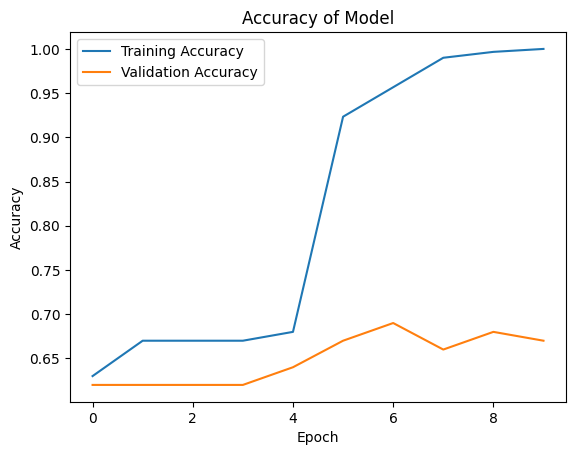

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

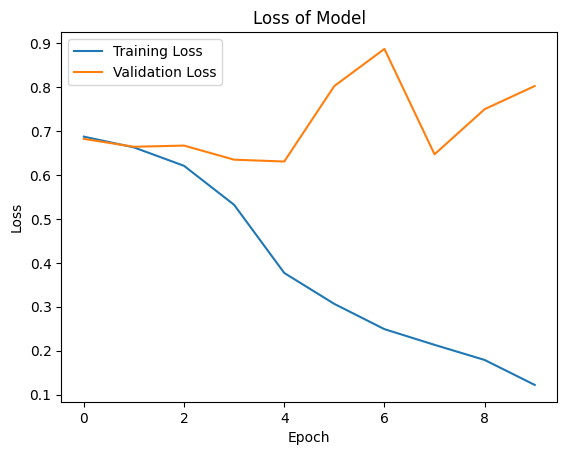

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss of Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Add dropout layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(validate_data)

7/7 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4200


[0.6934406757354736, 0.41999998688697815]

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=validate_data)

Epoch 1/10
19/19 [==============================] - 6s 24ms/step - loss: 0.6905 - accuracy: 0.6100 - val_loss: 0.6888 - val_accuracy: 0.6200
Epoch 2/10
19/19 [==============================] - 0s 26ms/step - loss: 0.6839 - accuracy: 0.6700 - val_loss: 0.6824 - val_accuracy: 0.6200
Epoch 3/10
19/19 [==============================] - 0s 24ms/step - loss: 0.6695 - accuracy: 0.6733 - val_loss: 0.6704 - val_accuracy: 0.6200
Epoch 4/10
19/19 [==============================] - 0s 24ms/step - loss: 0.6602 - accuracy: 0.6633 - val_loss: 0.6615 - val_accuracy: 0.6200
Epoch 5/10
19/19 [==============================] - 0s 26ms/step - loss: 0.6128 - accuracy: 0.6667 - val_loss: 0.6482 - val_accuracy: 0.6200
Epoch 6/10
19/19 [==============================] - 0s 23ms/step - loss: 0.5340 - accuracy: 0.6567 - val_loss: 0.6351 - val_accuracy: 0.6200
Epoch 7/10
19/19 [==============================] - 0s 23ms/step - loss: 0.4412 - accuracy: 0.7467 - val_loss: 0.7925 - val_accuracy: 0.6800
Epoch 8/10
19

In [ ]:
model.evaluate(test_data)

7/7 [==============================] - 0s 7ms/step - loss: 0.8637 - accuracy: 0.6600


[0.8636837005615234, 0.6600000262260437]

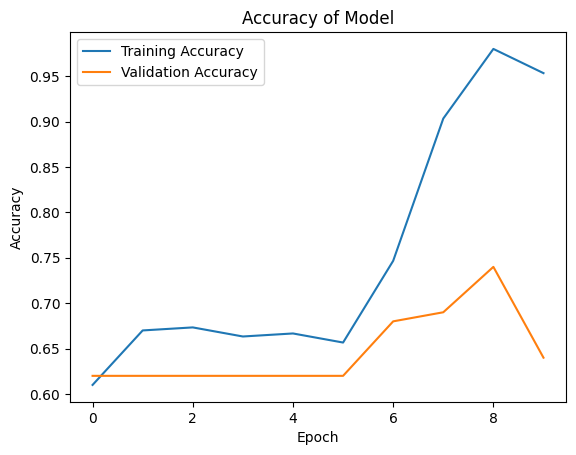

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Not much improvement :(

Let's make a model with half as many epochs

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=validate_data)

Epoch 1/5
19/19 [==============================] - 7s 107ms/step - loss: 0.6859 - accuracy: 0.6433 - val_loss: 0.6809 - val_accuracy: 0.6200
Epoch 2/5
19/19 [==============================] - 0s 25ms/step - loss: 0.6633 - accuracy: 0.6667 - val_loss: 0.6674 - val_accuracy: 0.6200
Epoch 3/5
19/19 [==============================] - 0s 24ms/step - loss: 0.6413 - accuracy: 0.6600 - val_loss: 0.6590 - val_accuracy: 0.6200
Epoch 4/5
19/19 [==============================] - 0s 23ms/step - loss: 0.5981 - accuracy: 0.6667 - val_loss: 0.6532 - val_accuracy: 0.6200
Epoch 5/5
19/19 [==============================] - 0s 24ms/step - loss: 0.5358 - accuracy: 0.6833 - val_loss: 0.6100 - val_accuracy: 0.6400


still not much better :(

perhaps we need to make more data!